In [2]:
import os, sys
import numpy as np
from tqdm import tqdm
import random
import cv2
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

sys.path.insert(0, os.path.abspath('..'))
from torch.utils.data import Dataset
import network.ael_net as net
from PIL import Image
from configs import datasets_config as config
from data import data_loader
import csv
from network import load_model
from configs.params import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.allow_tf32 = True

boiler_path = config.main_path['main'].replace('data', '')
method = 'ael_net' # folder name to store t-SNE graph
title = 'AELNet' # Title of t-SNE graph
graph_boiler_path = os.path.join(boiler_path, 'graphs/tsne', method)
if not os.path.exists(graph_boiler_path):
    os.makedirs(graph_boiler_path)

# path of image lists (TXT file) to be used for plotting
train_file_source = str(boiler_path) + 'data/visualization/tsne/img_lists/training_face.txt'
train_file_target = str(boiler_path) + 'data/visualization/tsne/img_lists/training_peri.txt'
# path of image lists corresponding to the location of TXT file
data_root_source = 'data/trainingdb/train/'
data_root_target = 'data/trainingdb/train/'

# load pre-trained model
embd_dim = 1024
load_model_path = '../models/best_model/AELNet.pth'
model = net.AEL_Net(embedding_size = embd_dim).eval().to(device)
model = load_model.load_pretrained_network(model, load_model_path, device = device)
print("Loaded the trained embedding layer and classifier(s) well.")

Loaded the trained embedding layer and classifier(s) well.


## Feature Extraction and t-SNE Graph Plotting Functions

In [3]:
def get_features(data_loader, model, peri_flag):
    # we'll store the features as NumPy array of size num_images x feature_size
    features = None

    # we'll also store the image labels and paths to visualize them later
    labels = []
    # image_paths = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Running the model inference'):
            images = batch[0].to(device)
            labels += batch[1].to(device)
            # image_paths += batch['image_path']
            # plot_graph(images)
            feat_outputs = model(images, peri_flag)
            current_features = feat_outputs.cpu().numpy()
            if features is not None:
                features = np.concatenate((features, current_features))
            else:
                features = current_features
    return features, labels #, image_paths


class ImageDataset(Dataset):
    def __init__(self, boiler_path, data_root, train_file, transforms , crop_eye=False, if_flip=True):
        self.boiler_path = boiler_path
        self.data_root = data_root
        self.train_list = []
        self.if_flip = if_flip
        train_file_buf = open(train_file)
        line = train_file_buf.readline().strip()
        self.transform = transforms
        while line:
            if " " in line:
                image_path, image_label = line.split(' ')
                self.train_list.append((image_path, int(image_label)))
                line = train_file_buf.readline().strip()
            else:
                image_path = line.split(' ')
                image_label = 'None'
                self.train_list.append((image_path, image_label))
                line = train_file_buf.readline().strip()
        self.crop_eye = crop_eye
        self.num_classes = sum([len(d) for r, d, folder in os.walk(data_root)])

    def __len__(self):
        return len(self.train_list)
    def __getitem__(self, index):
        image_path, image_label = self.train_list[index]
        image_path = self.boiler_path + self.data_root + image_path
        image_path = os.path.join(image_path)
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, image_label


def main_extract_features():
    data_trans = transforms.Compose( [ transforms.Resize((112,112)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
                                        ] )

    data_loader_source = DataLoader(ImageDataset(boiler_path, data_root_source, train_file_source, transforms= data_trans), 
                                100, num_workers = 4,drop_last=False)
    data_loader_target = DataLoader(ImageDataset(boiler_path, data_root_target, train_file_target, transforms= data_trans), 
                                100, num_workers = 4,drop_last=False)
                                
    model.eval()

    features_source, labelsS = get_features(data_loader_source, 
                model, peri_flag=False)

    features_target, labelsT = get_features(data_loader_target, 
                model, peri_flag=True)

    return features_source, features_target, labelsS, labelsT


def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image


def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape

    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color, thickness=5)

    return image


def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y


def visualize_tsne_images(tx, ty, images, labels, plot_size=1000, max_image_size=100):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, label, x, y in tqdm(
            zip(images, labels, tx, ty),
            desc='Building the T-SNE plot',
            total=len(images)
    ):
        image = cv2.imread(image_path)

        # scale the image to put it to the plot
        image = scale_image(image, max_image_size)

        # draw a rectangle with a color corresponding to the image class
        image = draw_rectangle_by_class(image, label)

        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    plt.imshow(tsne_plot[:, :, ::-1])
    plt.show()


def visualize_tsne(tsne, image_paths, title, labels, colors_per_class, marker_per_class, plot_size=1000, max_image_size=100, visualization='per_domain_visual'):
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    # # scale and move the coordinates so they fit [0; 1] range
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    # visualize the plot: samples as colored points
    visualize_tsne_points(tx, ty, labels, image_paths, title, colors_per_class, marker_per_class, visualization)


def visualize_tsne_points(tx, ty, labels, image_paths, title, colors_per_class, marker_per_class, visualization):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams.update({'font.size': 20, 'legend.fontsize': 17})    
    # initialize matplotlib plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_size_inches(20, 15)
    ax2 = ax.twiny()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    color_list = []
    marker_list = []
    color = None
    marker = None
    # for every class, we'll add a scatter plot separately
    for label_num in colors_per_class:
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(labels) if l == label_num]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)   

        # convert the class color to matplotlib format:
        # BGR -> RGB, divide by 255, convert to np.array
        color_first = np.array([colors_per_class[label_num][::-1]], dtype=float) / 255
        marker_first = marker_per_class[label_num]
        if not (color_first==color).all():
            color_list.append(color_first)
            color = color_first
        if not (marker_first==marker):
            marker_list.append(marker_first)
            marker = marker_first
        # add a scatter plot with the correponding color and label
        if visualization == "per_domain_visual":
            ax.scatter(current_tx, current_ty, c=color, marker=marker_per_class[label_num], s=300, alpha=0.35, edgecolors='grey')

        if visualization == "per_class_visual":
            ax.scatter(current_tx, current_ty, c=color, label=str(label_num + 1), marker=marker_per_class[label_num],s=200, alpha=0.95, edgecolors='grey')         
    
    if visualization == "per_domain_visual":
        for idx, area in enumerate(['Face', 'Periocular']):
            plt.scatter([], [], c=color_list[idx], alpha=1, label=area, marker=marker_list[idx])
        lgnd = plt.legend(scatterpoints=1, frameon=True, labelspacing=1, prop={'size': 16}, numpoints=5) #    plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Labels', prop={'size': 12})
        lgnd.legend_handles[0]._sizes = [250]
        lgnd.legend_handles[1]._sizes = [250]
        # plt.legend(handles = [plt.plot([],ls="-", color=line.get_color())[0]],
        #    labels=[line.get_label()])
    elif visualization == "per_class_visual":
        # build a legend using the labels we set previously
        # ax.legend(loc='upper right', title = 'Face', framealpha=1.0)
        from matplotlib.lines import Line2D

        legend_elements_face = []
        legend_elements_peri = []
        for i in range (0, 20):
            if i > 9:
                legend_elements_face.append(Line2D([0], [0], marker='*', color=color_list[i], label=str(i + 1 - 10), markersize=15, alpha=0.95, linestyle='None'))
            else:
                legend_elements_peri.append(Line2D([0], [0], marker='o', color=color_list[i], label=str(i + 1), markersize=15, alpha=0.95, linestyle='None'))
        ax.legend(handles=legend_elements_face, loc='upper right', title='Face')
        ax2.legend(handles=legend_elements_peri, loc='upper left', title='Periocular')
    # finally, show the plot
    plt.title(title)
    plt.show()
    fig.savefig(image_paths, bbox_inches='tight')

## Classifier-Related

In [4]:
load_psi_1_fc_path = load_model_path.replace('best_model', 'best_psi_1')
load_psi_2_fc_path = load_model_path.replace('best_model', 'best_psi_2')
load_psi_3_fc_path = load_model_path.replace('best_model', 'best_psi_3')
load_psi_4_fc_path = load_model_path.replace('best_model', 'best_psi_4')

psi_1 = torch.load(load_psi_1_fc_path, map_location=device)
psi_2 = torch.load(load_psi_2_fc_path, map_location=device)
psi_3 = torch.load(load_psi_3_fc_path, map_location=device)
psi_4 = torch.load(load_psi_4_fc_path, map_location=device)

# prototype
psi_1_pts = psi_1['weight']
psi_2_pts = psi_2['weight']
psi_3_pts = psi_3['weight']
psi_4_pts = psi_4['weight']

# Face Images
face_train_dir = config.trainingdb['face_train']
face_loader_train, face_train_set = data_loader.gen_data(face_train_dir, 'train', type='face', aug='False')
# Periocular Images
peri_train_dir = config.trainingdb['peri_train']
peri_loader_train, peri_train_set = data_loader.gen_data(peri_train_dir, 'train', type='face', aug='False')

label_dict = {}
for index, label in enumerate(peri_train_set.classes):
    label_dict[label] = index

file_list_dict = {}
train_file_buf = train_file_source
with open(train_file_buf, 'r') as csvfile:
    lines = list(csv.reader(csvfile, delimiter='\t'))[1:]
for line in lines:
    index = (line[0].split(' ')[-1])
    label = (line[0].split('/')[-2])
    file_list_dict[label] = index

psi_1_toy_prototype = torch.Tensor([]).to(device)
psi_2_toy_prototype = torch.Tensor([]).to(device)
psi_3_toy_prototype = torch.Tensor([]).to(device)
psi_4_toy_prototype = torch.Tensor([]).to(device)

for i in file_list_dict:
    psi_1_toy_prototype = torch.cat((psi_1_toy_prototype, psi_1_pts[label_dict[i]].unsqueeze(dim=0).to(device)), dim=0)
    psi_2_toy_prototype = torch.cat((psi_2_toy_prototype, psi_2_pts[label_dict[i]].unsqueeze(dim=0).to(device)), dim=0)
    psi_3_toy_prototype = torch.cat((psi_3_toy_prototype, psi_3_pts[label_dict[i]].unsqueeze(dim=0).to(device)), dim=0)
    psi_4_toy_prototype = torch.cat((psi_4_toy_prototype, psi_4_pts[label_dict[i]].unsqueeze(dim=0).to(device)), dim=0)

psi_1_toy_prototype = F.normalize(psi_1_toy_prototype, p=2, dim=1)
psi_2_toy_prototype = F.normalize(psi_2_toy_prototype, p=2, dim=1)
psi_3_toy_prototype = F.normalize(psi_3_toy_prototype, p=2, dim=1)
psi_4_toy_prototype = F.normalize(psi_4_toy_prototype, p=2, dim=1)

## Extract Features, Labels, and Plot t-SNE Graph

In [5]:
output = main_extract_features()
features_source, features_target, labelsS, labelsT = output

# Show Prototype Weights in Plot (Psi 1-4)
# features = np.concatenate((features_source, features_target, psi_1_toy_prototype.cpu().numpy(), psi_2_toy_prototype.cpu().numpy(), psi_3_toy_prototype.cpu().numpy(), psi_4_toy_prototype.cpu().numpy()),axis=0)
# labels = np.concatenate((torch.Tensor(labelsS).cpu().numpy(), torch.Tensor(labelsT).cpu().numpy()+10, torch.Tensor(torch.arange(20, 30, 1)), torch.Tensor(torch.arange(30, 40, 1)), torch.Tensor(torch.arange(40, 50, 1)), torch.Tensor(torch.arange(50, 60, 1))),axis=0)

# Do Not Show Prototype Weights in Plot
features = np.concatenate((features_source, features_target),axis=0)
labels = np.concatenate((torch.Tensor(labelsS).cpu().numpy(), torch.Tensor(labelsT).cpu().numpy()+10),axis=0)
tsne = TSNE(n_components=2).fit_transform(features)

Running the model inference: 100%|██████████| 17/17 [00:00<00:00, 18.85it/s]


## Separation by Domain

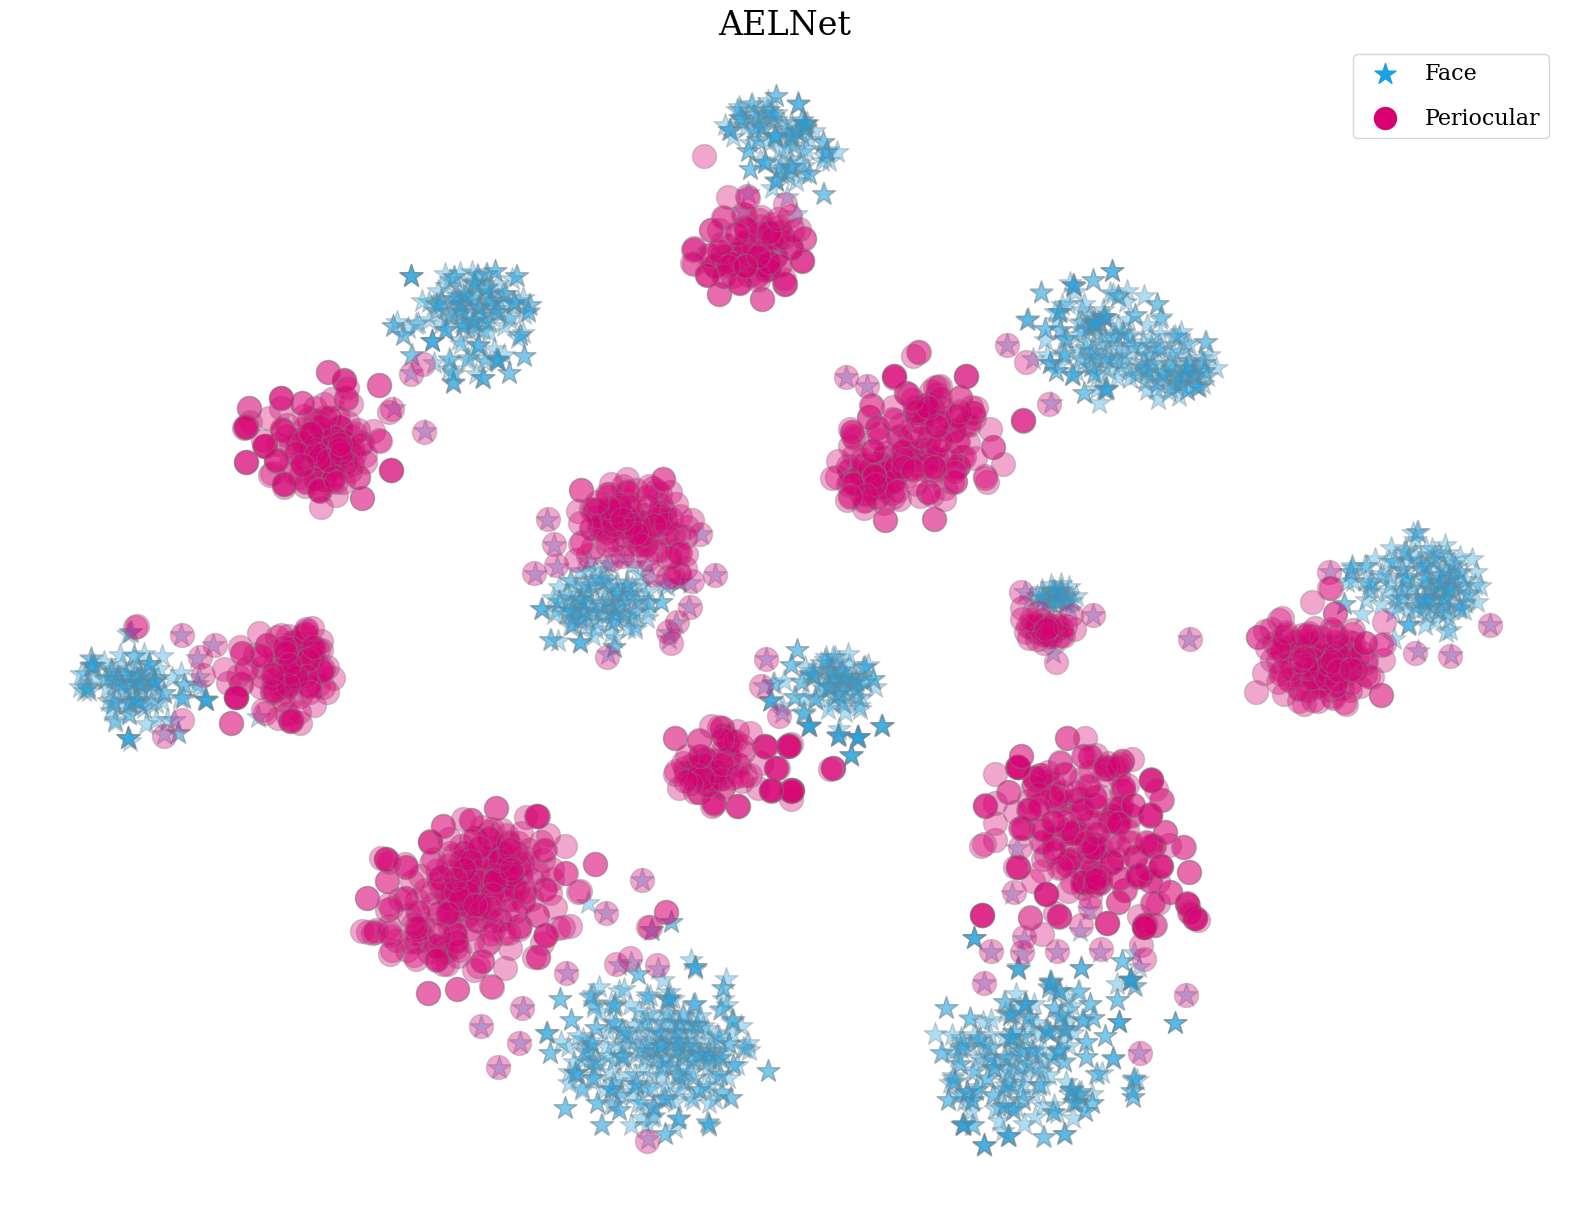

In [6]:
colors_per_class = {
    0 : [226, 161, 27],
    1 : [226, 161, 27],
    2 : [226, 161, 27],
    3 : [226, 161, 27],
    4 : [226, 161, 27],
    5 : [226, 161, 27],
    5 : [226, 161, 27],
    6 : [226, 161, 27],
    7 : [226, 161, 27],
    8 : [226, 161, 27],
    9 : [226, 161, 27],
    10: [115,  0, 216],
    11: [115,  0, 216],
    12: [115,  0, 216],
    13: [115,  0, 216],
    14: [115,  0, 216],
    15: [115,  0, 216],
    16: [115,  0, 216],
    17: [115,  0, 216],
    18: [115,  0, 216],
    19: [115,  0, 216],
    20: [0, 0, 0],
    21: [0, 0, 0],
    22: [0, 0, 0],
    23: [0, 0, 0],
    24: [0, 0, 0],
    25: [0, 0, 0],
    26: [0, 0, 0],
    27: [0, 0, 0],
    28: [0, 0, 0],
    29: [0, 0, 0],
    
    30: [0, 0, 0],
    31: [0, 0, 0],
    32: [0, 0, 0],
    33: [0, 0, 0],
    34: [0, 0, 0],
    35: [0, 0, 0],
    36: [0, 0, 0],
    37: [0, 0, 0],
    38: [0, 0, 0],
    39: [0, 0, 0],

    40: [0, 0, 0],
    41: [0, 0, 0],
    42: [0, 0, 0],
    43: [0, 0, 0],
    44: [0, 0, 0],
    45: [0, 0, 0],
    46: [0, 0, 0],
    47: [0, 0, 0],
    48: [0, 0, 0],
    49: [0, 0, 0],


    50: [0, 0, 0],
    51: [0, 0, 0],
    52: [0, 0, 0],
    53: [0, 0, 0],
    54: [0, 0, 0],
    55: [0, 0, 0],
    56: [0, 0, 0],
    57: [0, 0, 0],
    58: [0, 0, 0],
    59: [0, 0, 0],


    }

marker_per_class = {   
    0 : "*",  
    1 : "*",  
    2 : "*",
    3 : "*",
    4 : "*",
    5 : "*",
    6 : "*",
    7 : "*",
    8 : "*",
    9 : "*",

    10: "o",
    11: "o",
    12: "o",
    13: "o",
    14: "o",
    15: "o",
    16: "o",
    17: "o",
    18: "o",
    19: "o",

    20: "D",
    21: "D",
    22: "D",
    23: "D",
    24: "D",
    25: "D",
    26: "D",
    27: "D",
    28: "D",
    29: "D",

    30: "X",
    31: "X",
    32: "X",
    33: "X",
    34: "X",
    35: "X",
    36: "X",
    37: "X",
    38: "X",
    39: "X",

    40: "P",
    41: "P",
    42: "P",
    43: "P",
    44: "P",
    45: "P",
    46: "P",
    47: "P",
    48: "P",
    49: "P",

    50: "v",
    51: "v",
    52: "v",
    53: "v",
    54: "v",
    55: "v",
    56: "v",
    57: "v",
    58: "v",
    59: "v",
    }

# for creating a responsive plot
image_paths = graph_boiler_path + '/peri_face_sep.pdf'
visualize_tsne(tsne, image_paths, title, labels, colors_per_class, marker_per_class, visualization="per_domain_visual")

## Separation by Class

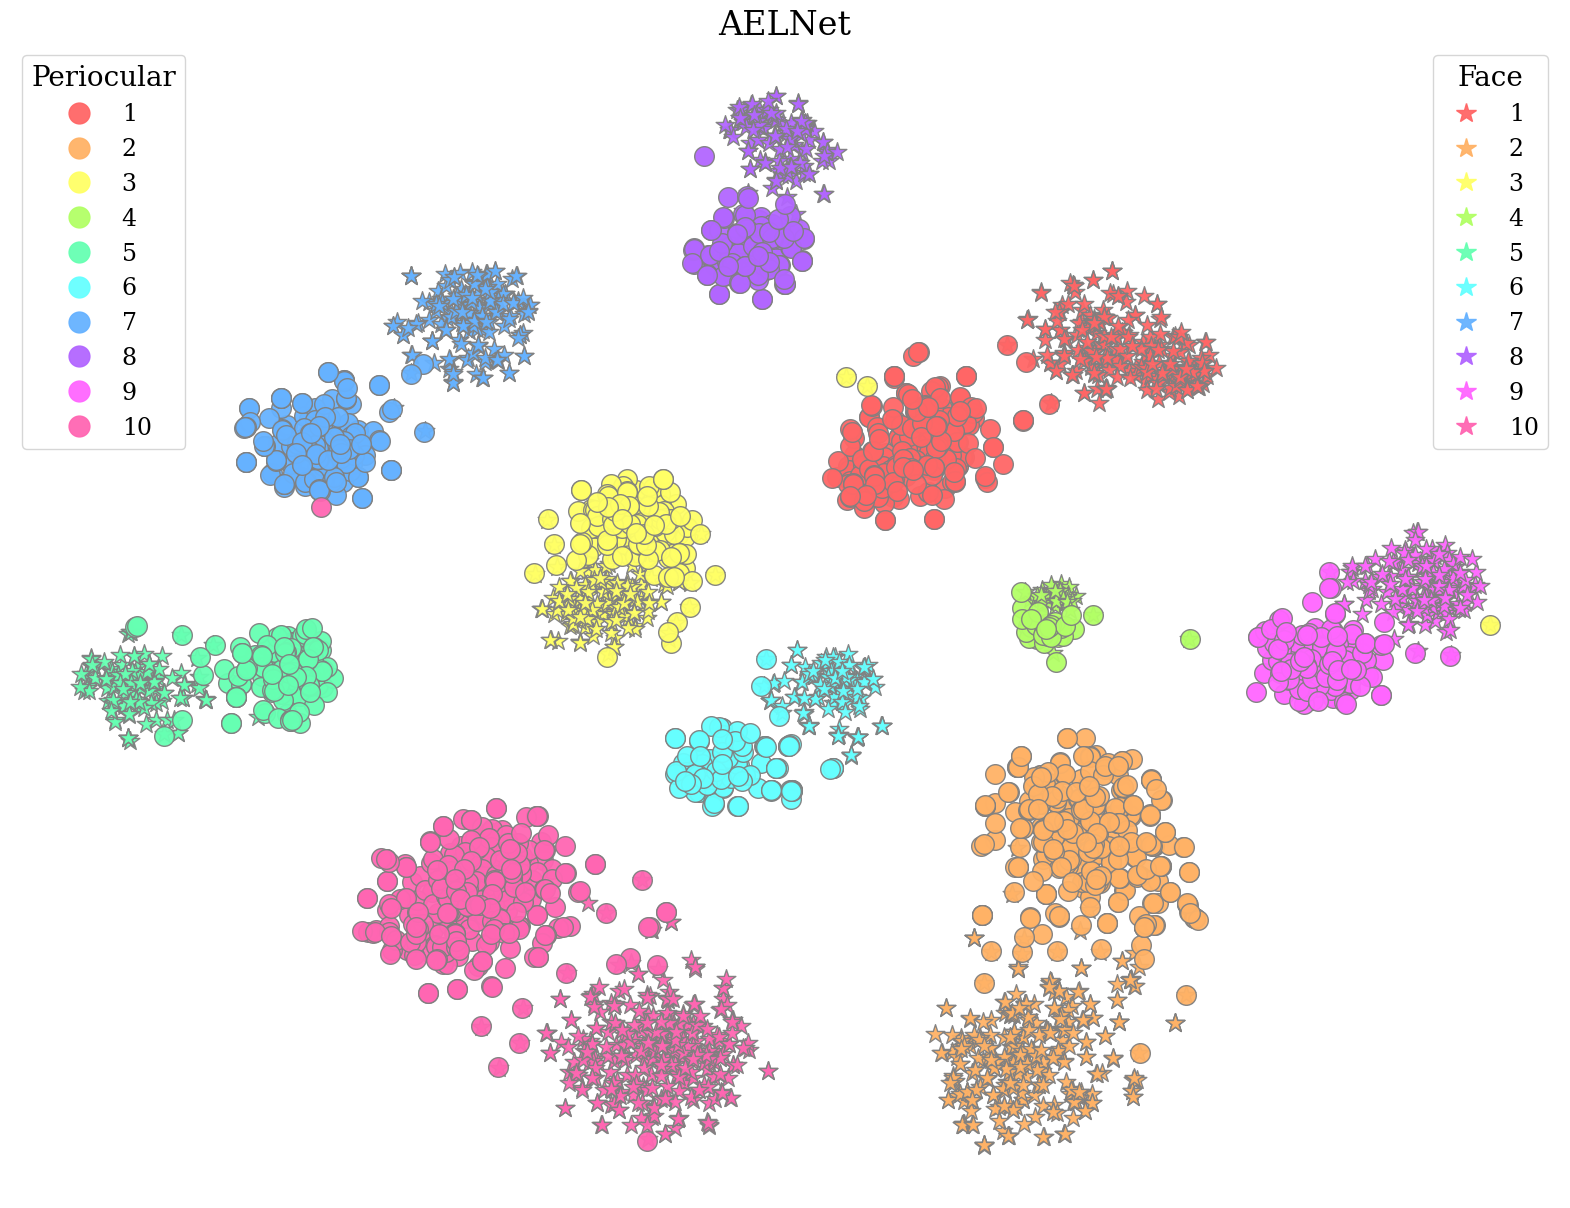

In [7]:
colors_per_class = {   # B, G, R
    0: [102,102,255],
    1: [102,178,255],
    2: [102,255,255],
    3: [102,255,178],
    4: [178,255,102],
    5: [255,255,102],
    6: [255,178,102],
    7: [255,102,178],
    8: [255,102,255],
    9: [178,102,255],

    10: [102,102,255],
    11: [102,178,255],
    12: [102,255,255],
    13: [102,255,178],
    14: [178,255,102],
    15: [255,255,102],
    16: [255,178,102],
    17: [255,102,178],
    18: [255,102,255],
    19: [178,102,255],
    
    20: [0, 0, 0],
    21: [0, 0, 0],
    22: [0, 0, 0],
    23: [0, 0, 0],
    24: [0, 0, 0],
    25: [0, 0, 0],
    26: [0, 0, 0],
    27: [0, 0, 0],
    28: [0, 0, 0],
    29: [0, 0, 0],

    30: [0, 0, 0],
    31: [0, 0, 0],
    32: [0, 0, 0],
    33: [0, 0, 0],
    34: [0, 0, 0],
    35: [0, 0, 0],
    36: [0, 0, 0],
    37: [0, 0, 0],
    38: [0, 0, 0],
    39: [0, 0, 0],
    
    40: [0, 0, 0],
    41: [0, 0, 0],
    42: [0, 0, 0],
    43: [0, 0, 0],
    44: [0, 0, 0],
    45: [0, 0, 0],
    46: [0, 0, 0],
    47: [0, 0, 0],
    48: [0, 0, 0],
    49: [0, 0, 0],

    50: [0, 0, 0],
    51: [0, 0, 0],
    52: [0, 0, 0],
    53: [0, 0, 0],
    54: [0, 0, 0],
    55: [0, 0, 0],
    56: [0, 0, 0],
    57: [0, 0, 0],
    58: [0, 0, 0],
    59: [0, 0, 0],
    }

marker_per_class = {   
    0 : "*",  
    1 : "*",  
    2 : "*",
    3 : "*",
    4 : "*",
    5 : "*",
    6 : "*",
    7 : "*",
    8 : "*",
    9 : "*",

    10: "o",
    11: "o",
    12: "o",
    13: "o",
    14: "o",
    15: "o",
    16: "o",
    17: "o",
    18: "o",
    19: "o",

    20: "D",
    21: "D",
    22: "D",
    23: "D",
    24: "D",
    25: "D",
    26: "D",
    27: "D",
    28: "D",
    29: "D",

    30: "X",
    31: "X",
    32: "X",
    33: "X",
    34: "X",
    35: "X",
    36: "X",
    37: "X",
    38: "X",
    39: "X",

    40: "P",
    41: "P",
    42: "P",
    43: "P",
    44: "P",
    45: "P",
    46: "P",
    47: "P",
    48: "P",
    49: "P",

    50: "v",
    51: "v",
    52: "v",
    53: "v",
    54: "v",
    55: "v",
    56: "v",
    57: "v",
    58: "v",
    59: "v",
    }

image_paths = graph_boiler_path + '/peri_face_sep_class.pdf'
visualize_tsne(tsne, image_paths, title, labels, colors_per_class, marker_per_class, visualization="per_class_visual")